# 用來測試訓練好的模型

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from settings import *

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes=2):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [14]:
model = LSTMClassifier(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, NUM_CLASSES)

In [15]:
model_path = "result/fold_4_model.pth"  # 根據要使用的模型權重檔案修改此路徑
model.load_state_dict(torch.load(model_path))
model.eval()  

/tmp/ipykernel_10778/2438317013.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


LSTMClassifier(
  (lstm): LSTM(3, 16, num_layers=4, batch_first=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

# 設定測試數據路徑

In [16]:
# test_normal_data_path = "dataset/normal/228_頭正常線正常.csv"  
# test_abnormal_data_path = "dataset/abnormal/228_頭正常線生鏽.csv" 
custom_data = "test.csv"
df = pd.read_csv(custom_data)

In [17]:
current = df['current'].values
voltage = df['voltage'].values
power = df['power'].values
sequence = np.column_stack((current, voltage, power))

In [18]:
sequences = []
seq_len = sequence.shape[0]
num_chunks = seq_len // MAX_SEQ_LEN
for i in range(num_chunks):
    start = i * MAX_SEQ_LEN
    end = start + MAX_SEQ_LEN
    chunk = sequence[start:end]
    sequences.append(chunk)

new_data = np.array(sequences, dtype=np.float32)

In [19]:
data_tensor = torch.tensor(new_data, dtype=torch.float32)

In [20]:
with torch.no_grad():
    outputs = model(data_tensor)
    _, predicted = torch.max(outputs, 1)

print("Predictions:", predicted)

for i, pred in enumerate(predicted):
    if pred == 1:
        print(f"Sequence {i} is predicted as abnormal.")
    else:
        print(f"Sequence {i} is predicted as normal.")


Predictions: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Sequence 0 is predicted as normal.
Sequence 1 is predicted as abnormal.
Sequence 2 is predicted as abnormal.
Sequence 3 is predicted as normal.
Sequence 4 is predicted as normal.
Sequence 5 is predicted as normal.
Sequence 6 is predicted as normal.
Sequence 7 is predicted as normal.
Sequence 8 is predicted as normal.
Sequence 9 is predicted as normal.
Sequence 10 is predicted as normal.
Sequence 11 is predicted as normal.
Sequence 12 is predicted as normal.
Sequence 13 is predicted as normal.
Sequence 14 is predicted as normal.
Sequence 15 is predicted as normal.
Sequence 16 is predicted as normal.
Sequence 17 is predicted as normal.
Sequence 18 is predicted as normal.
Sequence 19 is predicted as normal.
Sequence 20 is predicted as normal.
Sequence 21 is predicted as normal.
Sequence 22 is predicted as abnormal.
Sequence 23 is predi

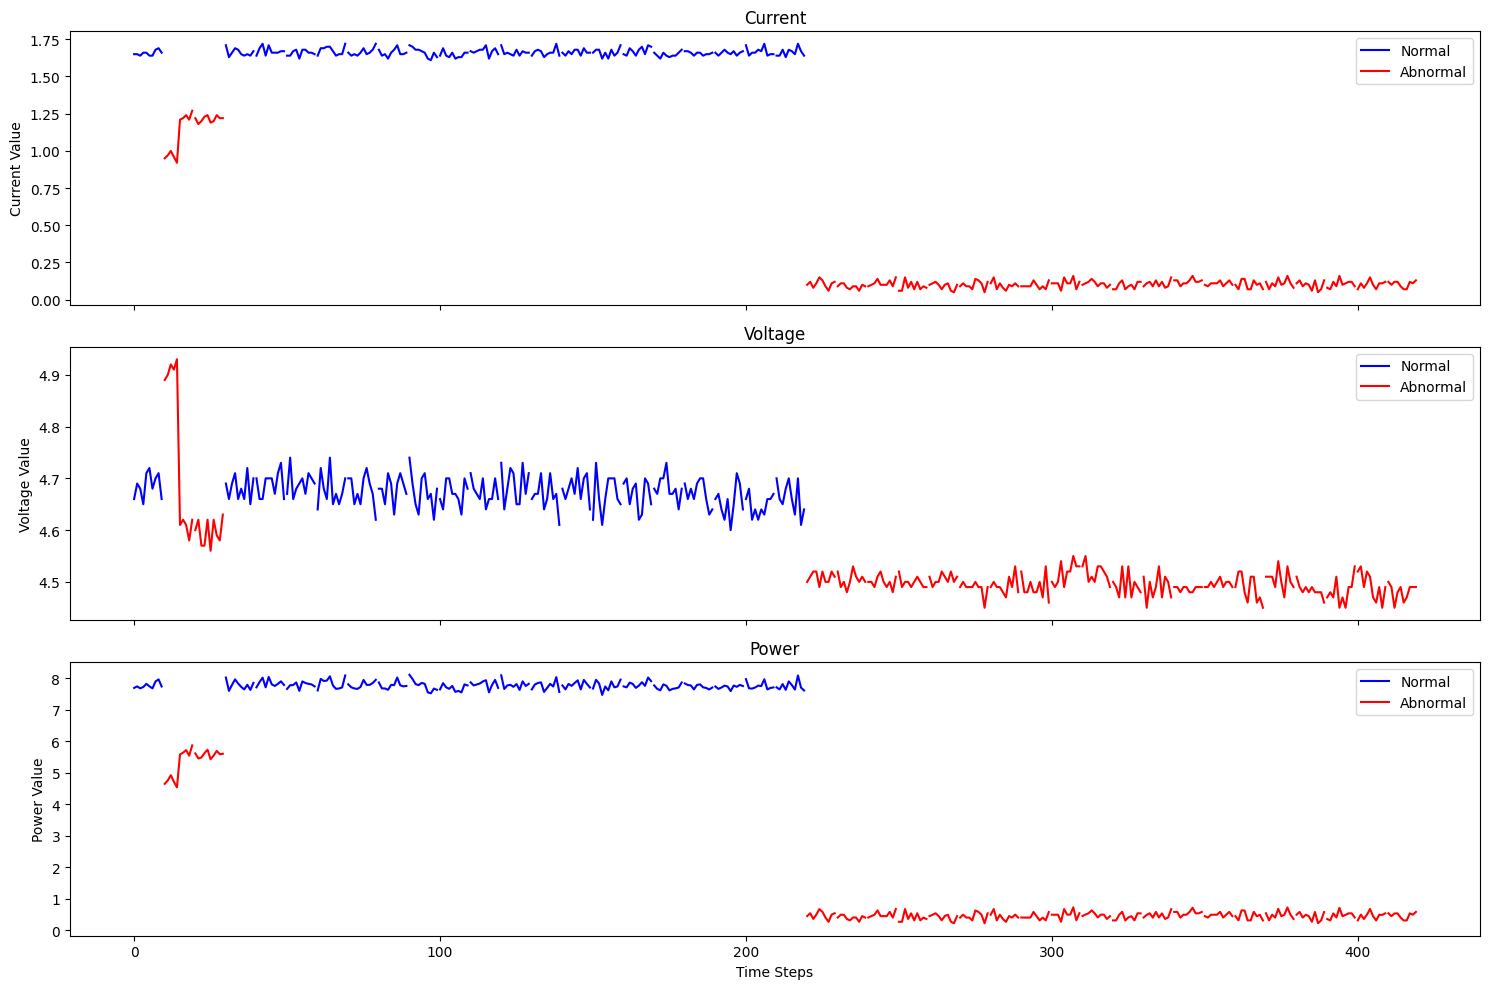

In [ ]:
time_steps = np.arange(seq_len)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for i in range(num_chunks):
    start = i * MAX_SEQ_LEN
    end = start + MAX_SEQ_LEN
    color = 'red' if predicted[i] == 1 else 'blue'  # 異常為紅色，正常為藍色
    ax1.plot(time_steps[start:end], sequence[start:end, 0], color=color)

for i in range(num_chunks):
    start = i * MAX_SEQ_LEN
    end = start + MAX_SEQ_LEN
    color = 'red' if predicted[i] == 1 else 'blue'
    ax2.plot(time_steps[start:end], sequence[start:end, 1], color=color)

for i in range(num_chunks):
    start = i * MAX_SEQ_LEN
    end = start + MAX_SEQ_LEN
    color = 'red' if predicted[i] == 1 else 'blue'
    ax3.plot(time_steps[start:end], sequence[start:end, 2], color=color)

ax1.set_title('Current')
ax1.set_ylabel('Current Value')
ax2.set_title('Voltage')
ax2.set_ylabel('Voltage Value')
ax3.set_title('Power')
ax3.set_ylabel('Power Value')
ax3.set_xlabel('Time Steps')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', label='Normal'),
                  Line2D([0], [0], color='red', label='Abnormal')]
ax1.legend(handles=legend_elements, loc='upper right')
ax2.legend(handles=legend_elements, loc='upper right')
ax3.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()